<a href="https://colab.research.google.com/github/phongpirik/CS2225.CH1501/blob/tungnqd/detect_age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


<IPython.core.display.Javascript object>

Saved to photo.jpg


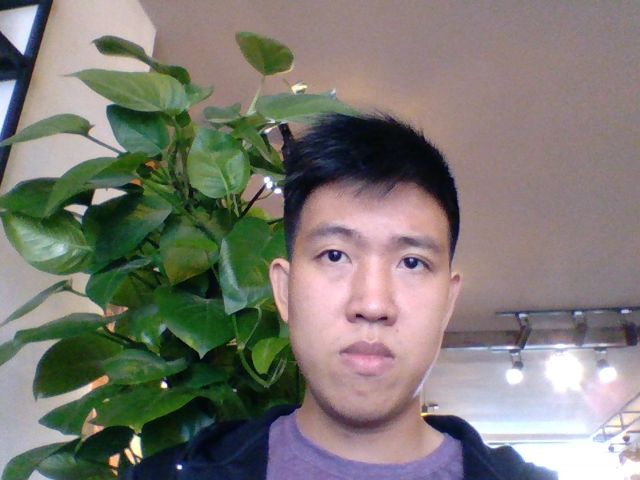

In [72]:
from IPython.display import Image
try:
  image_1 = take_photo()
  print('Saved to {}'.format(image_1))
  
  # Show the image which was just taken.
  display(Image(image_1))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [73]:
# import the necessary packages
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow
# from os.path import dirname, join

In [80]:
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=False,
	help="path to input image")
ap.add_argument("-f", "--face", required=False,
	help="path to face detector model directory")
ap.add_argument("-a", "--age", required=False,
	help="path to age detector model directory")
ap.add_argument("-g", "--gender", required=False,
	help="path to gender detector model directory")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

In [58]:
!pip install gdown

!pwd
!mkdir opencv-age-detection
!mkdir opencv-age-detection/face_detector
!mkdir opencv-age-detection/age_detector
!mkdir opencv-age-detection/gender_detector

/content
mkdir: cannot create directory ‘opencv-age-detection’: File exists
mkdir: cannot create directory ‘opencv-age-detection/face_detector’: File exists
mkdir: cannot create directory ‘opencv-age-detection/age_detector’: File exists
mkdir: cannot create directory ‘opencv-age-detection/gender_detector’: File exists


In [85]:
import gdown 

# deploy.prototxt
url = "https://drive.google.com/uc?id=1LzKm15hg_7tJwKhfG9-xC7w2-1PQqR0-" 
dest = "opencv-age-detection/face_detector/deploy.prototxt"
gdown.download(url, dest, quiet=False) 

url = "https://drive.google.com/uc?id=1BQERdF1VT3K_SodTNtmqXpNEm9sybXx6"
dest = "opencv-age-detection/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
gdown.download(url, dest, quiet=False) 

#age_deploy.prototxt

url = "https://drive.google.com/uc?id=1PNKZTOWG8qMoeYjUL6uATxwZjoqmbz4s" 
dest = "opencv-age-detection/age_detector/age_deploy.prototxt"
gdown.download(url, dest, quiet=False) 

url = "https://drive.google.com/uc?id=1M4_8h3m7NaLIOn9qhMnXQCSOJtBhBpkP" 
dest = "opencv-age-detection/age_detector/age_net.caffemodel"
gdown.download(url, dest, quiet=False)

#gender_deploy.prototxt

url = "https://drive.google.com/drive/u/4/folders/1EohLX9m3KrY_UoJrWZXhlMLpyPZHoaf9"
dest = "opencv-age-detection/gender_detector/gender_deploy.prototxt"
gdown.download(url, dest, quiet=False) 

url = "https://drive.google.com/drive/u/4/folders/1EohLX9m3KrY_UoJrWZXhlMLpyPZHoaf9" 
dest = "opencv-age-detection/gender_detector/gender_net.caffemodel"
gdown.download(url, dest, quiet=False)

/usr/local/lib/python3.6/dist-packages/gdown/parse_url.py:31: UserWarning: You specified Google Drive Link but it is not the correct link to download the file. Maybe you should try: https://drive.google.com/uc?id=None
  .format(url='https://drive.google.com/uc?id={}'.format(file_id))
Downloading...
From: https://drive.google.com/drive/u/4/folders/1F0jQ4epIxjSxJn2p-XuP5fIWh43Jtrp6
To: /content/opencv-age-detection/face_detector/deploy.prototxt
191kB [00:01, 161kB/s]
Downloading...
From: https://drive.google.com/drive/u/4/folders/1F0jQ4epIxjSxJn2p-XuP5fIWh43Jtrp6
To: /content/opencv-age-detection/face_detector/res10_300x300_ssd_iter_140000.caffemodel
183kB [00:00, 703kB/s]
Downloading...
From: https://drive.google.com/drive/u/4/folders/1O1eaScs0kKnarJeNGQa5BF0qYgCatsYu
To: /content/opencv-age-detection/age_detector/age_deploy.prototxt
191kB [00:00, 600kB/s]
Downloading...
From: https://drive.google.com/drive/u/4/folders/1O1eaScs0kKnarJeNGQa5BF0qYgCatsYu
To: /content/opencv-age-detection/

'opencv-age-detection/gender_detector/gender_net.caffemodel'

In [79]:
# define the list of age buckets our age detector will predict
AGE_BUCKETS = ["(0-2)", "(4-6)", "(8-12)", "(15-20)", "(25-32)", "(38-43)", "(48-53)", "(60-100)"]

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "opencv-age-detection//face_detector//deploy.prototxt"
weightsPath = "opencv-age-detection//face_detector//res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load our serialized age detector model from disk
print("[INFO] loading age detector model...")
prototxtPath = "opencv-age-detection//age_detector//age_deploy.prototxt"
weightsPath = "opencv-age-detection//age_detector//age_net.caffemodel"
ageNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the input image and construct an input blob for the image
image = cv2.imread(image_1)
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))
# blob = cv.dnn.blobFromImage(face, 1, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
faceNet.setInput(blob)
detections = faceNet.forward()

# gender detector
print("[INFO] computing gender detections...")
genderProto = "opencv-age-detection//gender_detector//gender_deploy.prototxt"
genderModel = "opencv-age-detection//gender_detector//gender_net.caffemodel"
genderList = ['Male', 'Female']
genderNet=cv2.dnn.readNet(genderModel,genderProto)

# print("Gender Output : {}".format(genderPreds))
# print("Gender : {}".format(gender))

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > args["confidence"]:
		# compute the (x, y)-coordinates of the bounding box for the
		# object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# extract the ROI of the face and then construct a blob from
		# *only* the face ROI
		face = image[startY:endY, startX:endX]
		faceBlob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),
			(78.4263377603, 87.7689143744, 114.895847746),
			swapRB=False)

		# make predictions on the age and find the age bucket with
		# the largest corresponding probability
		ageNet.setInput(faceBlob)
		preds = ageNet.forward()
		i = preds[0].argmax()
		age = AGE_BUCKETS[i]
		ageConfidence = preds[0][i]

		# gender input
		# genderNet.setInput(blob)
		# genderPreds = genderNet.forward()
		# gender = genderList[genderPreds[0].argmax()]

		# display the predicted age to our terminal
		text = "{}: {:.2f}%".format(age, ageConfidence * 100)
		# text = "{} {}: {:.2f}%".format(gender, age, ageConfidence * 100)
		print("[INFO] {}".format(text))

		# draw the bounding box of the face along with the associated
		# predicted age
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),
			(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

# display the output image
cv2_imshow(image)
cv2.waitKey(0)

[INFO] loading face detector model...
[INFO] loading age detector model...
[INFO] computing face detections...
[INFO] computing gender detections...


error: ignored

In [70]:
#A Gender and Age Detection program by Mahesh Sawant

import cv2
import math
import argparse

def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn=frame.copy()
    frameHeight=frameOpencvDnn.shape[0]
    frameWidth=frameOpencvDnn.shape[1]
    blob=cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections=net.forward()
    faceBoxes=[]
    for i in range(detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>conf_threshold:
            x1=int(detections[0,0,i,3]*frameWidth)
            y1=int(detections[0,0,i,4]*frameHeight)
            x2=int(detections[0,0,i,5]*frameWidth)
            y2=int(detections[0,0,i,6]*frameHeight)
            faceBoxes.append([x1,y1,x2,y2])
            cv2.rectangle(frameOpencvDnn, (x1,y1), (x2,y2), (0,255,0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn,faceBoxes


# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=False,
	help="path to input image")
ap.add_argument("-f", "--face", required=False,
	help="path to face detector model directory")
ap.add_argument("-a", "--age", required=False,
	help="path to age detector model directory")
ap.add_argument("-g", "--gender", required=False,
	help="path to gender detector model directory")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

faceProto="opencv-age-detection//face_detector//opencv_face_detector.pbtxt"
faceModel="opencv-age-detection//face_detector//opencv_face_detector_uint8.pb"
ageProto="opencv-age-detection//age_detector//age_deploy.prototxt"
ageModel="opencv-age-detection//ace_detector//age_net.caffemodel"
genderProto="opencv-age-detection//gender_detector//gender_deploy.prototxt"
genderModel="opencv-age-detection//gender_detector//gender_net.caffemodel"

MODEL_MEAN_VALUES=(78.4263377603, 87.7689143744, 114.895847746)
ageList=['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList=['Male','Female']

faceNet=cv2.dnn.readNet(faceModel,faceProto)
ageNet=cv2.dnn.readNet(ageModel,ageProto)
genderNet=cv2.dnn.readNet(genderModel,genderProto)

video=cv2.VideoCapture(args.image if args.image else 0)
padding=20
while cv2.waitKey(1)<0 :
    hasFrame,frame=video.read()
    if not hasFrame:
        cv2.waitKey()
        break
    
    resultImg,faceBoxes=highlightFace(faceNet,frame)
    if not faceBoxes:
        print("No face detected")

    for faceBox in faceBoxes:
        face=frame[max(0,faceBox[1]-padding):
                   min(faceBox[3]+padding,frame.shape[0]-1),max(0,faceBox[0]-padding)
                   :min(faceBox[2]+padding, frame.shape[1]-1)]

        blob=cv2.dnn.blobFromImage(face, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds=genderNet.forward()
        gender=genderList[genderPreds[0].argmax()]
        print(f'Gender: {gender}')

        ageNet.setInput(blob)
        agePreds=ageNet.forward()
        age=ageList[agePreds[0].argmax()]
        print(f'Age: {age[1:-1]} years')

        cv2.putText(resultImg, f'{gender}, {age}', (faceBox[0], faceBox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2, cv2.LINE_AA)
        cv2.imshow("Detecting age and gender", resultImg)

error: ignored